In [24]:
import numpy as np
import os
import matplotlib.pyplot as plt
import h5py
from scipy import interpolate
#from ccfj import GetStationPairs
import pandas as pd
import yaml
import geopandas as gp
import openpyxl
from openpyxl import load_workbook
from concurrent.futures import ThreadPoolExecutor

from scipy.interpolate import make_interp_spline
from scipy.stats import ks_2samp
from scipy.spatial import ConvexHull

In [25]:
import sys
sys.path.append(r'../tools_F-J/')
from toollib_standard import maplib
from toollib_standard import mathlib
from toollib_standard import filelib
from toollib_standard import plotlib

In [26]:
with open('a-project_repar.yml', 'r', encoding='utf-8') as f:
    proj = yaml.load(f.read(), Loader=yaml.FullLoader)
name_project = proj['name']
#name_project = 'project_repartrition/output_repar_03-01/'               # Harmon server
name_project

'project_repartition_v4.0/output_repar_v9.5_04--10-16Hz/'

In [27]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = os.path.join(dir_project_workspace, name_project)
print('dir_project: ', dir_project)

dir_CC_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project:  /shdisk/rem2/Harmon/F-J/San/project_repartition_v4.0/output_repar_v9.5_04--10-16Hz/


In [28]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [29]:
rdir_project_probes = info_basic['rdir_project_probes']
rdir_project_targets = info_basic['rdir_project_targets']
dir_project_probes = os.path.join(dir_project_workspace, rdir_project_probes)
dir_project_targets = os.path.join(dir_project_workspace, rdir_project_targets)
print('dir_project_probes: ', dir_project_probes)
print('dir_project_targets: ', dir_project_targets)

dir_project_probes:  /shdisk/rem2/Harmon/F-J/San/project/output_regular_v9.5_3x7/
dir_project_targets:  /shdisk/rem2/Harmon/F-J/San/project/output_regular_v9.5_5x13/


In [30]:
filename = dir_project_probes+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic_probes = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project_probes+'Basic_info.npy'
info_basic_bi_probes = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

filename = dir_project_targets+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic_targets = yaml.load(f.read(), Loader=yaml.FullLoader)

In [31]:
probes = info_basic_probes['key_subworks']
targets = info_basic_targets['key_subworks']
key_subworks = info_basic['key_subworks']

In [32]:
stalistname_all = info_basic['stalistname_all']
stainfo = pd.read_excel(stalistname_all)
nsta_all = len(stainfo.iloc[:,0])
StationPairs_all = mathlib.GetStationPairs(nsta_all)
nPairs_all = int(len(StationPairs_all)/2)
stalist_all = stainfo['Station'].tolist()
lat_stations_all = stainfo['latitude'].tolist() 
lon_stations_all = stainfo['longitude'].tolist()

In [33]:
dir_partition = dir_project + info_basic['rdir_partition']
dir_partition_probes = dir_project_probes + info_basic_probes['rdir_partition']
dir_partition_targets = dir_project_targets + info_basic_targets['rdir_partition']
dir_image = dir_project + info_basic['rdir_image'] + 'post_K-S_analysis/'
if not os.path.exists(dir_image):
    os.makedirs(dir_image)

In [34]:
stations_probes = {}
lat_probes = {}
lon_probes = {}
for probe in probes:
    filepath = dir_partition_probes + str(probe) + '.txt'
    stations_this, lat_stations_this, lon_stations_this = np.loadtxt(filepath, dtype='str' , unpack=True)
    stations_probes[probe] = stations_this
    lat_probes[probe] = lat_stations_this.astype(float)
    lon_probes[probe] = lon_stations_this.astype(float)

stations_targets = {}
lat_targets = {}
lon_targets = {}
for target in targets:
    filepath = dir_partition_targets + str(target) + '.txt'
    stations_this, lat_stations_this, lon_stations_this = np.loadtxt(filepath, dtype='str' , unpack=True)
    stations_targets[target] = stations_this
    lat_targets[target] = lat_stations_this.astype(float)
    lon_targets[target] = lon_stations_this.astype(float)

stations = {}
lat = {}
lon = {}
for key in key_subworks:
    filepath = dir_partition + str(key) + '.txt'
    stations_this, lat_stations_this, lon_stations_this = np.loadtxt(filepath, dtype='str' , unpack=True)
    stations[key] = stations_this
    lat[key] = lat_stations_this.astype(float)
    lon[key] = lon_stations_this.astype(float)

In [35]:
faults = np.load('clark_faults.npy', allow_pickle='TRUE').item()
probe_accept_all = info_basic_bi['probe_accept']

In [36]:
# read disp data
disp_all = {}
ff_all = {}
ds_probe_all = {}
for probe in probes:
    file_disp = dir_project_probes  + info_basic_probes['rdir_disp_autopick'] + 'autopick_'+probe+'.txt'
    disp_all[probe] = np.loadtxt(file_disp,delimiter=',')[:,1]
    ff_all[probe] = np.loadtxt(file_disp,delimiter=',')[:,0]
    file_ds = dir_project_probes  + info_basic_probes['rdir_ds'] + 'ds_'+probe+'.h5'
    ds = h5py.File(file_ds,'r')
    ds_probe_all[probe] = ds['ds_remove'][0]
    ds.close()

### Analysis

In [37]:
def new_target_comparison(key_subwork):
    global c_lim
    global probe_ref
    target = key_subwork[key_subwork.find('--')+2:]
    probes = info_basic_bi['probe'][key_subwork]
    probes_accept = probe_accept_all[target]

    # all stations
    lat_stations_this = lat[key_subwork]
    lon_stations_this = lon[key_subwork]

    # probe stations
    lat_stations_target = lat_targets[target]
    lon_stations_target = lon_targets[target]

    #plt.cla()
    fig = plt.figure(figsize=(14,10),clear=True)
    # partition comparison
    ax = plt.subplot(221)
    ax.scatter(lon_stations_all, lat_stations_all,marker='.',color='k',s=1)
    ax.scatter(np.mean(lon_stations_this), np.mean(lat_stations_this),marker='o',color='b',s=50,label='New center')
    ax.scatter(lon_stations_this, lat_stations_this,marker='o',color='g',s=20,label='New partition')
    ax.scatter(np.mean(lon_stations_target), np.mean(lat_stations_target),marker='^',color='b',s=50,label='Target center')
    ax.scatter(lon_stations_target, lat_stations_target,marker='^',color='r',s=5,label= 'Target partition')
    for i in range(len(faults)):
        ax.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k--', lw=1)
    ax.axis('off')
    ax.legend()
    # probe accepted comparison
    ax = plt.subplot(222)
    ax.scatter(lon_stations_all, lat_stations_all,marker='.',color='k',s=1)
    ax.scatter(lon_stations_this, lat_stations_this,marker='o',color='g',s=5,label='New partition')
    ax.axis('off')
    for i in range(len(faults)):
        ax.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k--', lw=1)
    #ax.scatter(lon_targets, lat_targets,marker='^',color='b',s=5,label= 'Target partition')

    flag_label_probe =  1
    flag_label_probe_accept =  1
    for probe in probes:
        if probe in probes_accept:
            if flag_label_probe_accept:
                ax.scatter(np.mean(lon_probes[probe]), np.mean(lat_probes[probe]),marker='*',color='r',s=30,label='Accepted Porbe center')
                flag_label_probe_accept = 0
            else:
                ax.scatter(np.mean(lon_probes[probe]), np.mean(lat_probes[probe]),marker='*',color='r',s=30)
        else:
            if flag_label_probe:
                ax.scatter(np.mean(lon_probes[probe]), np.mean(lat_probes[probe]),marker='*',color='b',s=5,label='Porbe center')
                flag_label_probe = 0
            else:
                ax.scatter(np.mean(lon_probes[probe]), np.mean(lat_probes[probe]),marker='*',color='b',s=5)
    ax.legend()
    # all disp comparison
    ax = plt.subplot(223)
    for probe in probes:
        ax.scatter(ff_all[probe], disp_all[probe],label=probe,s=1)
    ax.set_ylim(c_lim)
    # accepted disp comparison
    ax = plt.subplot(224)
    flag_label_probe =  1
    flag_label_probe_accept =  1
    for probe in probes:
        if probe == probe_ref:
            index = np.argsort(ff_all[probe])
            ax.plot(ff_all[probe][index], disp_all[probe][index],'k--',label='reference',lw=4)
        elif probe in probes_accept:
            if flag_label_probe_accept:
                ax.scatter(ff_all[probe], disp_all[probe],label='accepted',s=1)
                flag_label_probe_accept = 0
            else:
                ax.scatter(ff_all[probe], disp_all[probe],s=1)
        """
        else:
            if flag_label_probe:
                ax.scatter(f_sample, disp_all[probe],label="unaccepted",s=0.5,color='b')
                flag_label_probe = 0
            else:
                ax.scatter(f_sample, disp_all[probe],s=0.5,color='b')
        """
    ax.set_ylim(c_lim)
    ax.legend()
    plt.savefig(dir_image+'new_target_comparison_'+key_subwork+'.png',dpi=100)
    #plt.close()

In [38]:
def plot_disp_all(key_subwork):
    global key_subworks
    global c_lim
    global dir_image
    global info_basic_bi
    global info_basic_bi_probes
    global info_basic_bi_targets
    global info_basic_probes
    global f_lim
    global probes_accept
    global probe_ref
    
    f = info_basic_bi_probes['f']
    c = np.linspace(info_basic_probes['fj_c_min'],info_basic_probes['fj_c_max'],info_basic_probes['fj_c_num'])
    num = len(probes)
    n_cols = int(np.ceil(np.sqrt(num)))+1
    n_rows = int(np.floor(np.sqrt(num)))
    #plt.cla()
    fig = plt.figure(figsize=(n_cols*3,n_rows*2),clear=True)
    for i in range(num):
        ax = plt.subplot(n_rows,n_cols,i+1)
        ax = plotlib.plot_fj(ax,ds_probe_all[probes[i]],probes[i],f,c,0,c_map='jet')
        ax.scatter(ff_all[probes[i]], disp_all[probes[i]],label=probes[i],s=1)
        ax.set_ylim(c_lim)
        ax.set_xlim(f_lim)
        ax.legend()
        if probes[i] == probe_ref:
            ax.set_title(probes[i]+' (reference)',color='g')
        elif probes[i] in probes_accept:
            ax.set_title(probes[i]+' (accepted)',color='r')
        else:
            ax.set_title(probes[i],color='b')
    plt.tight_layout()
    plt.savefig(dir_image+'disp_all_'+key_subwork+'.png',dpi=60)
    #plt.close()

In [39]:
nums_repick = [2]
key_subworks = []
for num in nums_repick:
    tag = str(num)
    for key_subwork in info_basic['key_subworks']:
        if tag == key_subwork.split('--')[0]:
            key_subworks.append(key_subwork)
#key_subworks = info_basic['key_subworks']
key_subworks

['2--53-17']

In [40]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

probe_accept_all = info_basic_bi['probe_accept']
probe_ref_all = info_basic_bi['probe_ref']

2--53-17


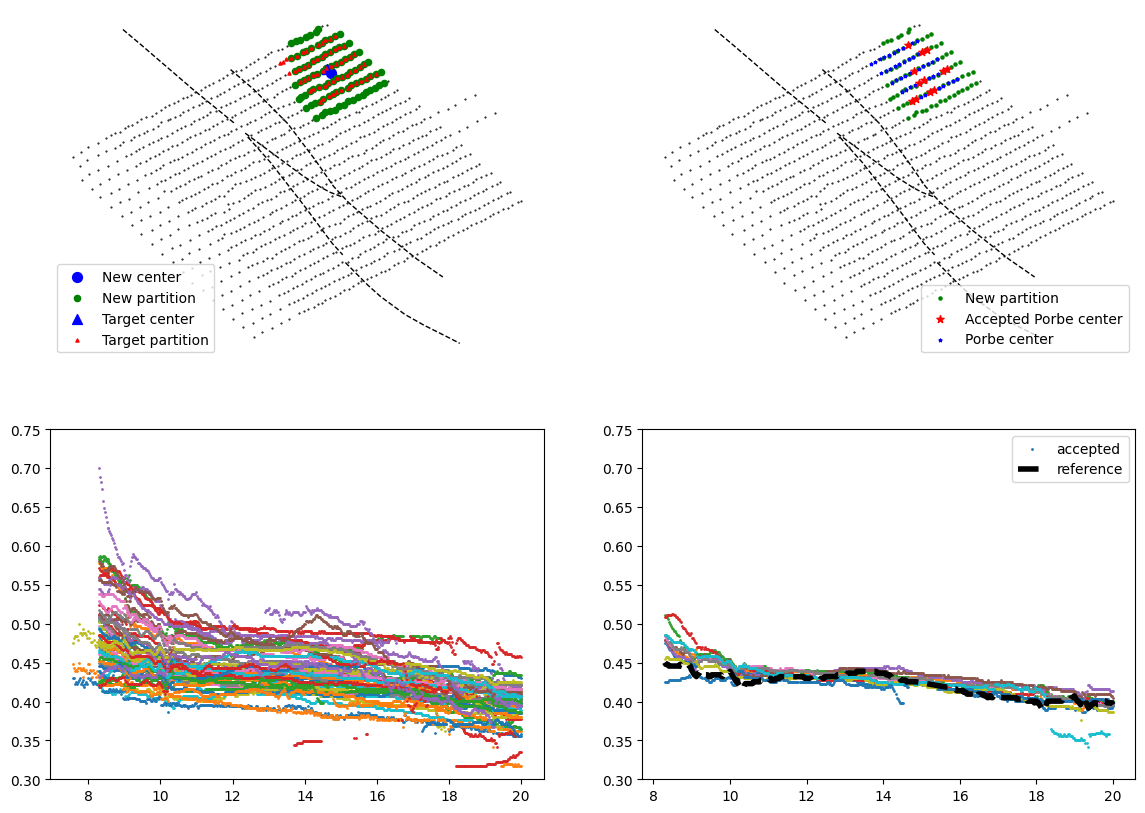

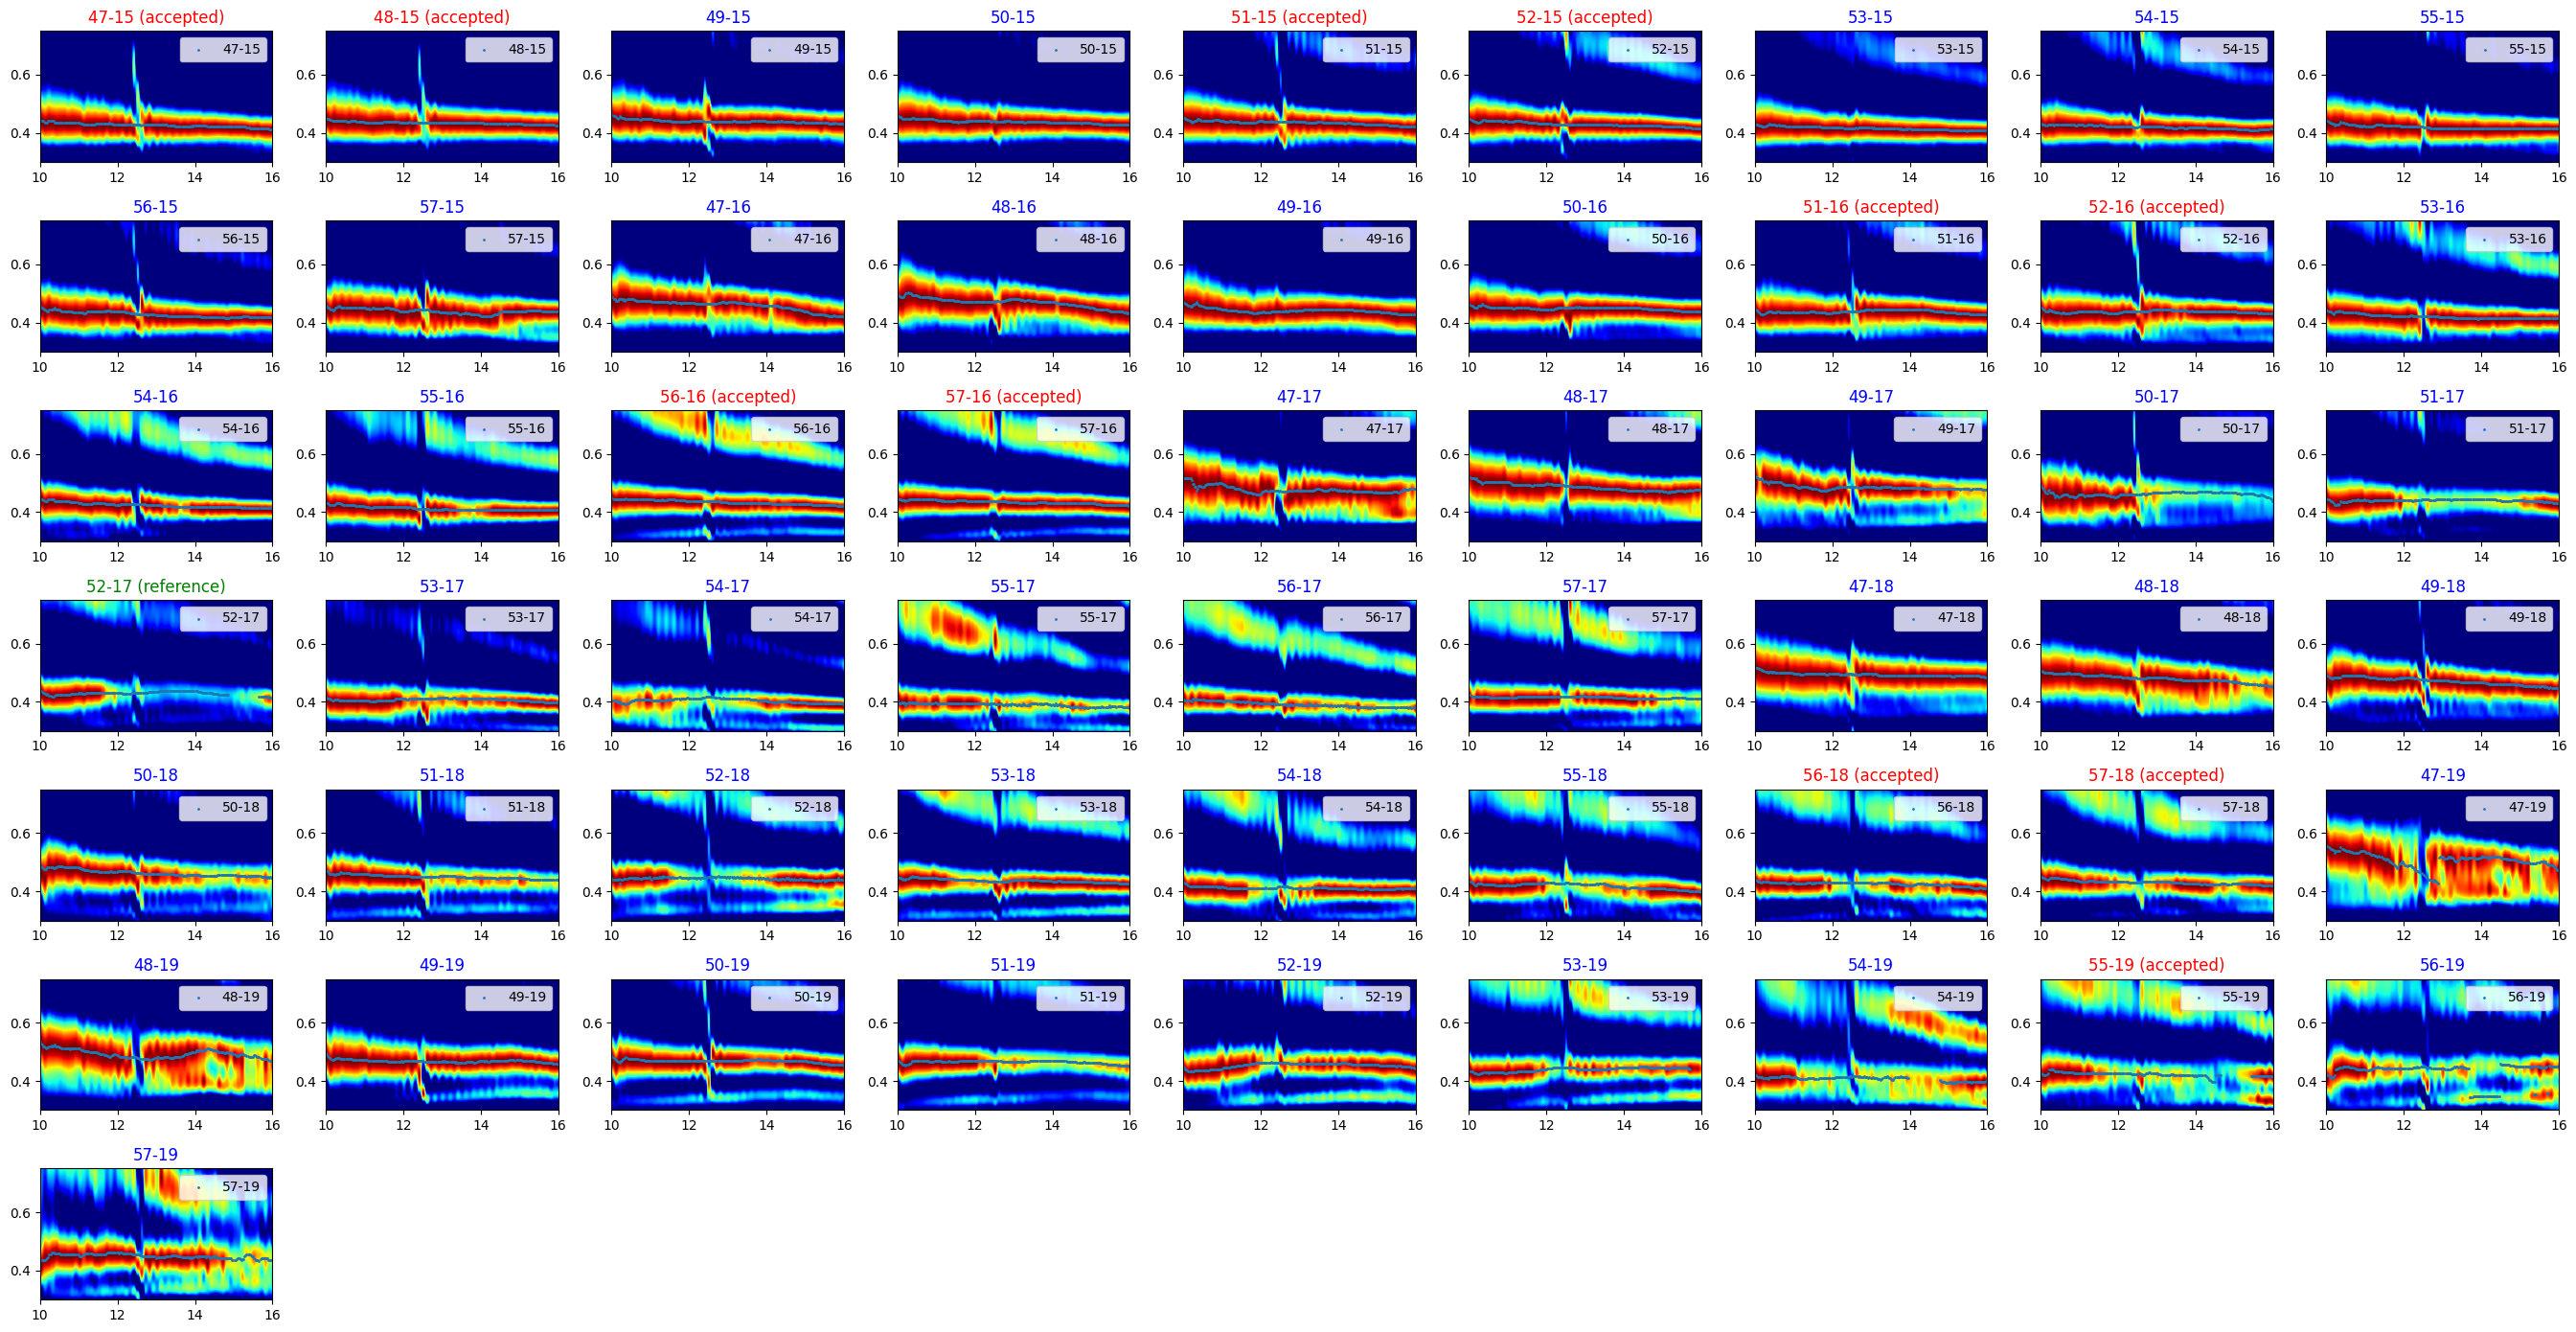

In [41]:
c_lim = [0.3,0.75]
f_lim = [10,16]
for key_subwork in key_subworks:
    print(key_subwork)
    target = key_subwork[key_subwork.find('--')+2:]
    probes = info_basic_bi['probe'][key_subwork]
    probes_accept = probe_accept_all[target]
    probe_ref = probe_ref_all[target]
    new_target_comparison(key_subwork)
    plot_disp_all(key_subwork)